In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 

from scipy import stats

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [14]:
df = pd.read_csv('detailed_ev_charging_stations.csv')

In [20]:
#Removing "Random Rd" and numbered cities entries to keep only valid addresses
df_filtered = df[~df['Address'].str.contains('Random Rd|City \d+', na=False, regex=True)]

In [16]:
#Basic information
print("Dataset Info (Valid Entries Only:")
print(df_filtered.info())

Dataset Info (Valid Entries Only:
<class 'pandas.core.frame.DataFrame'>
Index: 4500 entries, 1 to 4999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Station ID                   4500 non-null   object 
 1   Latitude                     4500 non-null   float64
 2   Longitude                    4500 non-null   float64
 3   Address                      4500 non-null   object 
 4   Charger Type                 4500 non-null   object 
 5   Cost (USD/kWh)               4500 non-null   float64
 6   Availability                 4500 non-null   object 
 7   Distance to City (km)        4500 non-null   float64
 8   Usage Stats (avg users/day)  4500 non-null   int64  
 9   Station Operator             4500 non-null   object 
 10  Charging Capacity (kW)       4500 non-null   int64  
 11  Connector Types              4500 non-null   object 
 12  Installation Year            4500 non-null   in

In [22]:
#Basic numerical statistics
print("\nNumerical Statistics (Valid Entries only):")
print(df_filtered.describe())


Numerical Statistics (Valid Entries only):
          Latitude    Longitude  Cost (USD/kWh)  Distance to City (km)  \
count  4500.000000  4500.000000     4500.000000            4500.000000   
mean     21.785652    10.039214        0.300776              10.183644   
std      28.439351    92.327869        0.115911               5.609258   
min     -33.899305  -122.499694        0.100000               0.500000   
25%      13.851484   -87.673557        0.200000               5.437500   
50%      34.078109    18.507158        0.300000              10.155000   
75%      41.810389   100.465345        0.400000              14.890000   
max      55.899682   151.399431        0.500000              20.000000   

       Usage Stats (avg users/day)  Charging Capacity (kW)  Installation Year  \
count                  4500.000000             4500.000000        4500.000000   
mean                     55.352000              143.081778        2016.556000   
std                      26.505635            

In [24]:
#Check for missing values
print("\nMissing Values (Valid Entries Only):")
print(df_filtered.isnull().sum())


Missing Values (Valid Entries Only):
Station ID                     0
Latitude                       0
Longitude                      0
Address                        0
Charger Type                   0
Cost (USD/kWh)                 0
Availability                   0
Distance to City (km)          0
Usage Stats (avg users/day)    0
Station Operator               0
Charging Capacity (kW)         0
Connector Types                0
Installation Year              0
Renewable Energy Source        0
Reviews (Rating)               0
Parking Spots                  0
Maintenance Frequency          0
dtype: int64


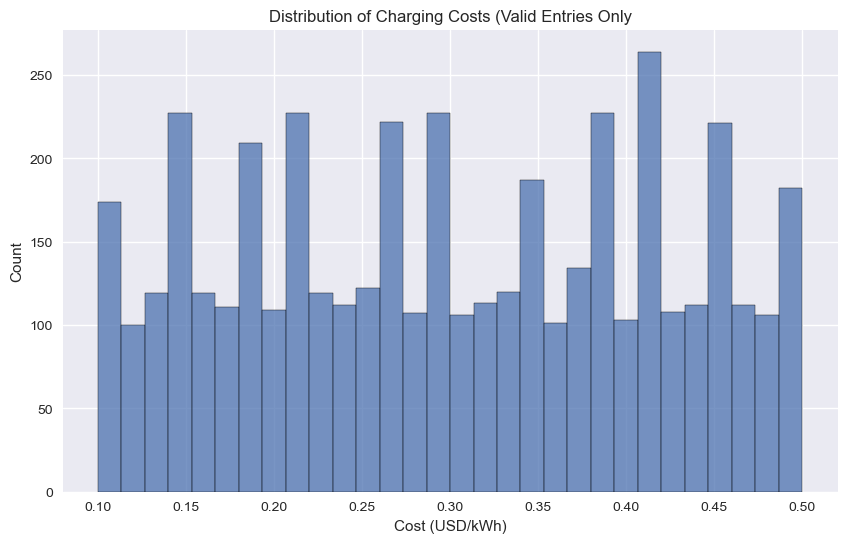

In [26]:
# Distribution of charging costs
plt.figure(figsize=(10,6))
sns.histplot(data=df_filtered, x='Cost (USD/kWh)', bins=30)
plt.title('Distribution of Charging Costs (Valid Entries Only')
plt.xlabel('Cost (USD/kWh)')
plt.show()

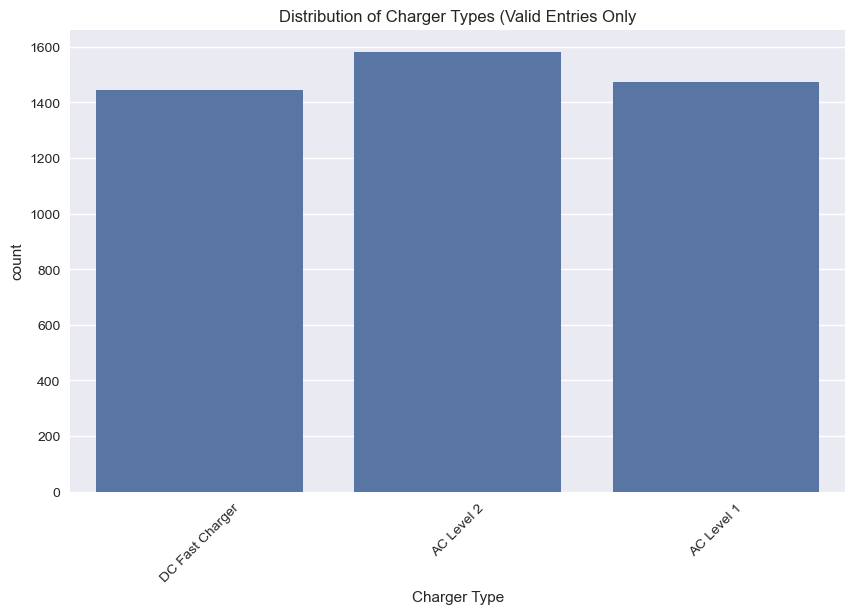

In [28]:
#Distribution of charger types
plt.figure(figsize=(10,6))
sns.countplot(data=df_filtered, x='Charger Type')
plt.title('Distribution of Charger Types (Valid Entries Only')
plt.xticks(rotation=45)
plt.show()

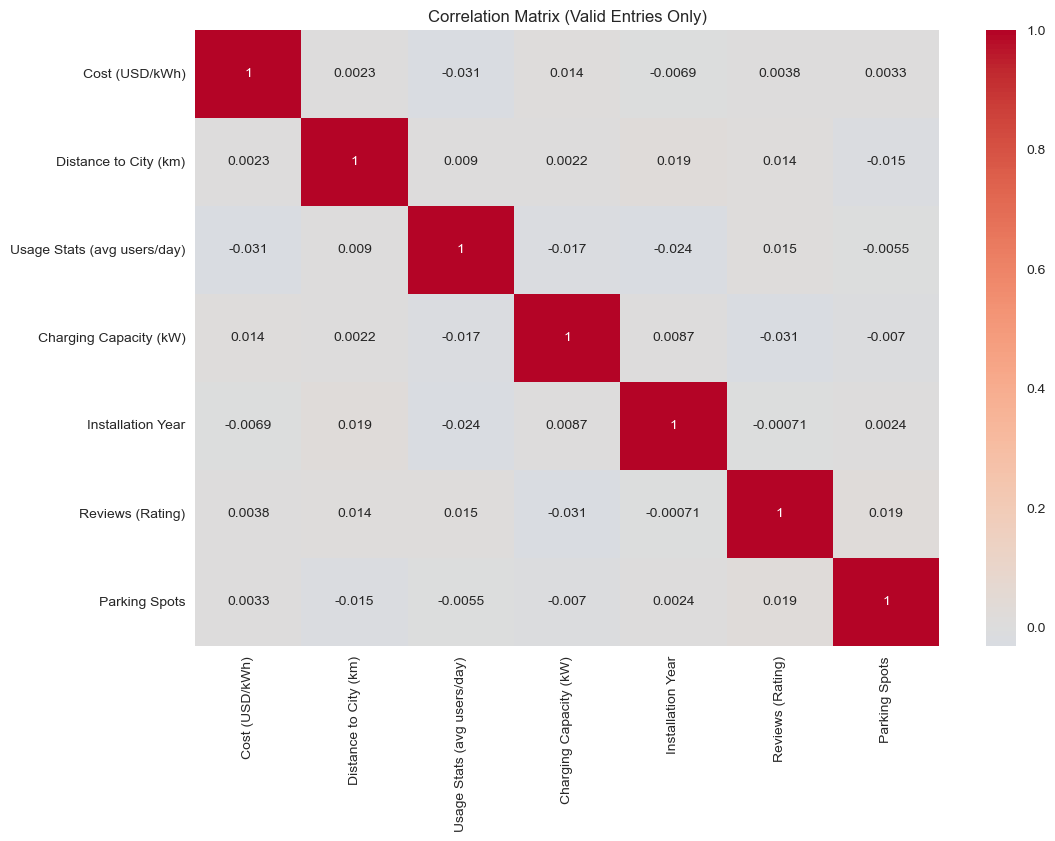

In [30]:
#Correlations matrix for numerical data
numerical_cols = ['Cost (USD/kWh)', 'Distance to City (km)', 'Usage Stats (avg users/day)', 'Charging Capacity (kW)', 'Installation Year', 'Reviews (Rating)', 'Parking Spots']
correlation_matrix = df_filtered[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix (Valid Entries Only)')
plt.show()

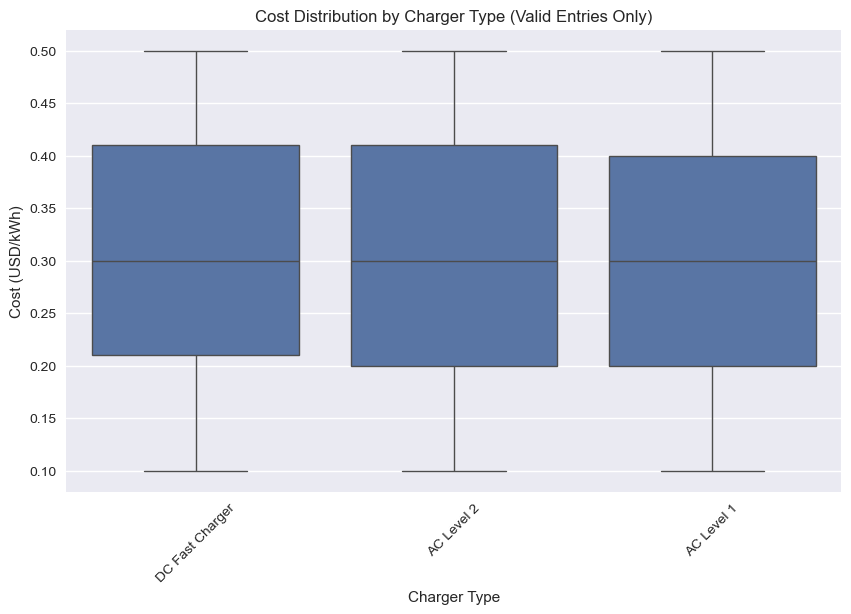

In [32]:
#Box plot for costs by charger type
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x='Charger Type', y='Cost (USD/kWh)')
plt.title('Cost Distribution by Charger Type (Valid Entries Only)')
plt.xticks(rotation=45)
plt.show()

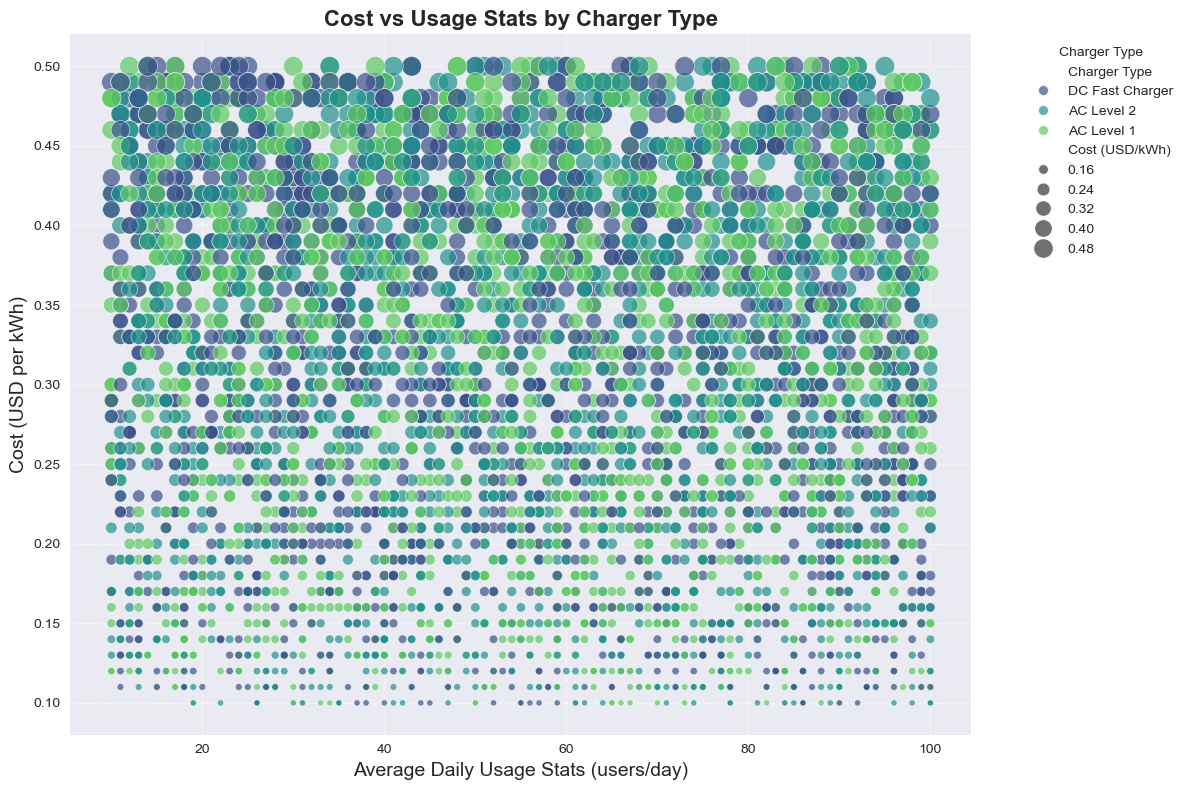

In [34]:
# Scatter plot of cost versus usage with enhancements
plt.figure(figsize=(12, 8))  # Larger figure size for readability
sns.scatterplot(data=df_filtered, 
                x='Usage Stats (avg users/day)', 
                y='Cost (USD/kWh)', 
                alpha=0.7,  # Slightly less transparency for clarity
                hue='Charger Type', 
                palette='viridis',  # Use a visually distinct color palette
                size='Cost (USD/kWh)',  # Optional: Size points based on cost
                sizes=(20, 200))  # Define size range for the points

# Add a grid for better readability
plt.grid(visible=True, linestyle='--', alpha=0.6)

# Set title with larger font
plt.title('Cost vs Usage Stats by Charger Type', fontsize=16, fontweight='bold')

# Add axis labels with larger font
plt.xlabel('Average Daily Usage Stats (users/day)', fontsize=14)
plt.ylabel('Cost (USD per kWh)', fontsize=14)

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Charger Type', fontsize=10)

# Tight layout to minimize white space
plt.tight_layout()

# Show the plot
plt.show()  

In [36]:
# Summary statistics by station operator 
print("\nSummary by Station Operator:")
operator_summary = df_filtered.groupby('Station Operator').agg({
    'Cost (USD/kWh)': ['mean', 'min', 'max', 'count'],
    'Reviews (Rating)': 'mean',
    'Usage Stats (avg users/day)': 'mean'
}).round(2)
print(operator_summary)


Summary by Station Operator:
                 Cost (USD/kWh)                 Reviews (Rating)  \
                           mean  min  max count             mean   
Station Operator                                                   
ChargePoint                0.30  0.1  0.5   903             3.98   
EVgo                       0.30  0.1  0.5   901             4.00   
Greenlots                  0.31  0.1  0.5   889             3.98   
Ionity                     0.30  0.1  0.5   879             3.98   
Tesla                      0.30  0.1  0.5   928             4.01   

                 Usage Stats (avg users/day)  
                                        mean  
Station Operator                              
ChargePoint                            55.43  
EVgo                                   56.54  
Greenlots                              56.42  
Ionity                                 54.24  
Tesla                                  54.16  


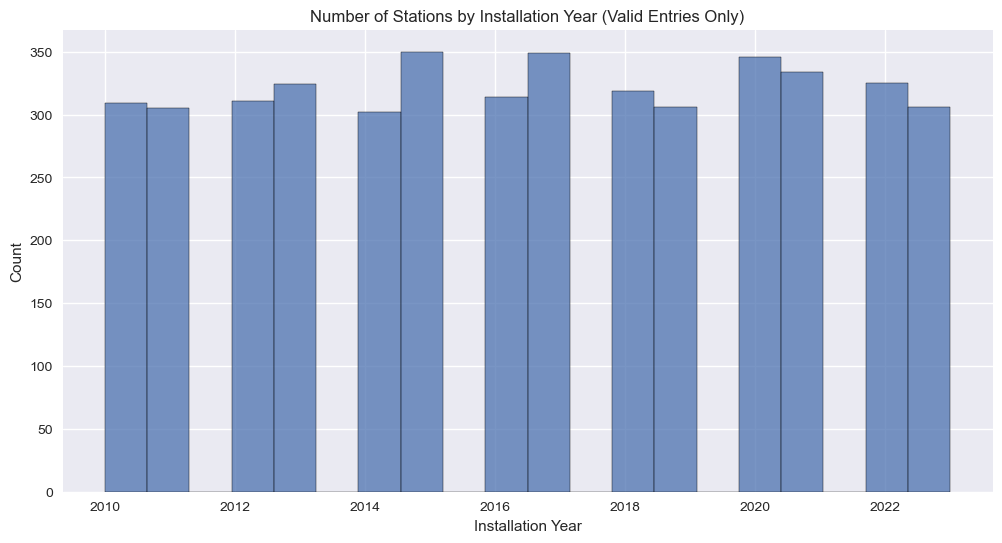

In [38]:
#Installation trends over time
plt.figure(figsize=(12, 6))
sns.histplot(data=df_filtered, x='Installation Year', bins=20)
plt.title('Number of Stations by Installation Year (Valid Entries Only)')
plt.show()

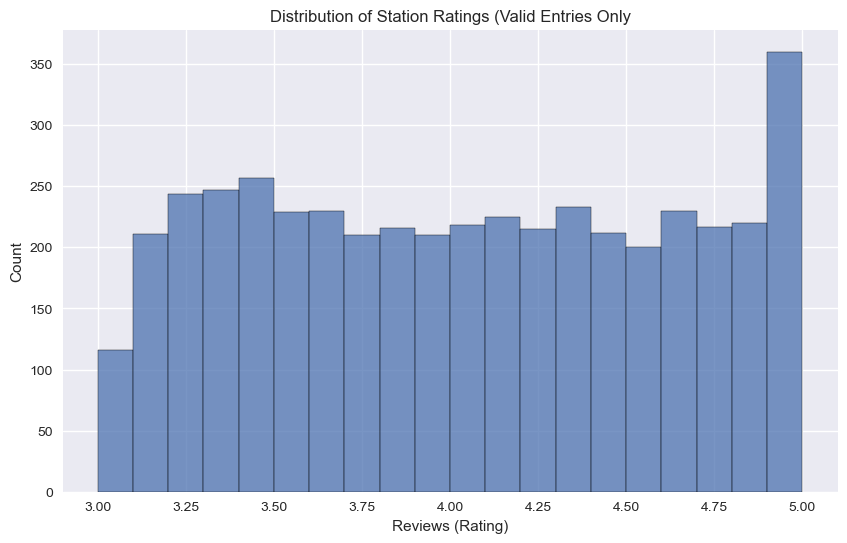

In [40]:
#Average ratings distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_filtered, x='Reviews (Rating)', bins=20)
plt.title('Distribution of Station Ratings (Valid Entries Only')
plt.show()

Analyzing address patterns in the dataset...

Address Pattern Analysis:

Number of 'Random Rd' addresses: 500

Sample of 'Random Rd' addresses:
0      4826 Random Rd, City 98, Country
10    7123 Random Rd, City 463, Country
20    6470 Random Rd, City 207, Country
30     8491 Random Rd, City 59, Country
40     1309 Random Rd, City 47, Country
Name: Address, dtype: object

Number of numbered city addresses: 500

Sample of numbered city addresses:
0      4826 Random Rd, City 98, Country
10    7123 Random Rd, City 463, Country
20    6470 Random Rd, City 207, Country
30     8491 Random Rd, City 59, Country
40     1309 Random Rd, City 47, Country
Name: Address, dtype: object

Number of potentially real addresses: 4500

Sample of potentially real addresses:
1    8970 San Francisco Ave, San Francisco
2                5974 Bangkok Ave, Bangkok
3                6995 Toronto Ave, Toronto
4                  5704 Mumbai Ave, Mumbai
5            1545 São Paulo Ave, São Paulo
Name: Address, dtype: ob

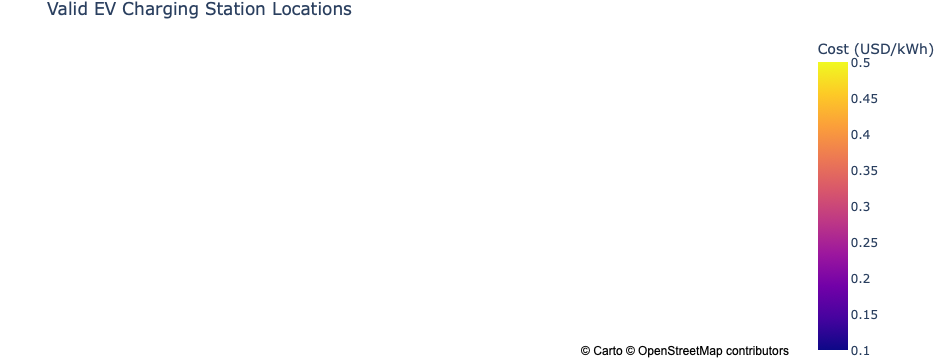

In [30]:
def is_valid_location(row, verbose=False):
    """
    Validate location data for a charging station
    
    Parameters:
    row (pd.Series): A row from the charging stations dataframe
    verbose (bool): If True, print reasons for invalidation
    
    Returns:
    bool: True if location appears valid, False otherwise
    """
    lat = row['Latitude']
    lon = row['Longitude']
    address = row['Address']
    
    # Filter out artificial addresses
    if ('Random Rd' in address or 
        'City' in address and any(char.isdigit() for char in address.split('City')[1].split(',')[0].strip())):
        if verbose:
            print(f"Artificial address detected: {address}")
        return False
    
    # Basic range check
    if not (-90 <= lat <= 90) or not (-180 <= lon <= 180):
        if verbose:
            print(f"Invalid range: {address} ({lat}, {lon})")
        return False
    
    # Check if coordinates match the city in the address
    for city, coords in CITY_COORDINATES.items():
        if city in address:
            # Check if coordinates fall within the expected range for this city
            lat_range = coords['lat']
            lon_range = coords['lon']
            if (lat_range[0] <= lat <= lat_range[1] and 
                lon_range[0] <= lon <= lon_range[1]):
                return True
            else:
                if verbose:
                    print(f"Coordinates don't match city: {address} ({lat}, {lon})")
                return False
    
    # Ocean checks
    pacific_ocean = {'lat': (-60, 60), 'lon': (-180, -120)}
    atlantic_ocean = {'lat': (-60, 60), 'lon': (-65, -15)}
    indian_ocean = {'lat': (-60, 20), 'lon': (50, 100)}
    
    def is_in_ocean(lat, lon, ocean):
        return (ocean['lat'][0] <= lat <= ocean['lat'][1] and 
                ocean['lon'][0] <= lon <= ocean['lon'][1])
    
    # If it's in the middle of any major ocean, it's probably wrong
    if (is_in_ocean(lat, lon, pacific_ocean) or 
        is_in_ocean(lat, lon, atlantic_ocean) or 
        is_in_ocean(lat, lon, indian_ocean)):
        if verbose:
            print(f"Location in ocean: {address} ({lat}, {lon})")
        return False
    
    return True

# Let's also add a function to analyze the address patterns
def analyze_address_patterns(df):
    """
    Analyze patterns in addresses to help identify artificial vs real entries
    """
    print("\nAddress Pattern Analysis:")
    
    # Sample of addresses containing "Random Rd"
    random_rd = df[df['Address'].str.contains('Random Rd', na=False)]
    print(f"\nNumber of 'Random Rd' addresses: {len(random_rd)}")
    print("\nSample of 'Random Rd' addresses:")
    print(random_rd['Address'].head())
    
    # Sample of addresses with numbered cities
    numbered_cities = df[df['Address'].str.contains(r'City \d+', na=False, regex=True)]
    print(f"\nNumber of numbered city addresses: {len(numbered_cities)}")
    print("\nSample of numbered city addresses:")
    print(numbered_cities['Address'].head())
    
    # Sample of remaining addresses
    real_addresses = df[~df['Address'].str.contains('Random Rd|City \d+', na=False, regex=True)]
    print(f"\nNumber of potentially real addresses: {len(real_addresses)}")
    print("\nSample of potentially real addresses:")
    print(real_addresses['Address'].head())
    
    return real_addresses

# Run the analysis before filtering
print("Analyzing address patterns in the dataset...")
analyze_address_patterns(df)

# Now apply the filtering and create the map as before
print("\nValidating station locations...")
total_stations = len(df)
df_filtered = df[df.apply(lambda x: is_valid_location(x, verbose=True), axis=1)]
valid_stations = len(df_filtered)

print(f"\nValidation Summary:")
print(f"Total stations: {total_stations}")
print(f"Valid stations: {valid_stations}")
print(f"Filtered out: {total_stations - valid_stations} stations")

# Create the map visualization with filtered data
print("\nCreating map visualization...")
fig = px.scatter_mapbox(df_filtered, 
                       lat='Latitude', 
                       lon='Longitude', 
                       color='Cost (USD/kWh)',
                       size='Usage Stats (avg users/day)',
                       hover_data=['Charger Type', 'Station Operator', 'Address'],
                       zoom=2,
                       title='Valid EV Charging Station Locations')

fig.update_layout(
    mapbox_style='carto-positron',
    mapbox=dict(
        center=dict(lat=20, lon=0),
    ),
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()